In [0]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import importlib
from torch.utils.data.sampler import SubsetRandomSampler

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
from google.colab import drive

In [58]:
drive.mount("/content/gdrive")
print("Mounted. Copying CelebA...")
!cp -r /content/gdrive/My\ Drive/celeba/ /content/celeba/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted. Copying CelebA...


In [0]:
def get_dataset(is_training:bool):
  if is_training:
    t = transforms.Compose(
          [
          transforms.RandomGrayscale(),
          transforms.RandomApply([transforms.RandomRotation(45)], p=0.1),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.ToTensor()
          ]
        )
  else:
    t = transforms.ToTensor()
  dataset = torchvision.datasets.celeba.CelebA("/content", download=True, transform=t, split="train" if is_training else "test")
  return dataset

In [0]:
def get_loader(is_training:bool, batch_size:int):
  dataset = get_dataset(is_training)
  return DataLoader(dataset, batch_size=batch_size, shuffle=is_training)

In [0]:
class FeatureClassifier(nn.Module):
  def __init__(self, n_inp, n_out):
    super(FeatureClassifier, self).__init__()
    midpoint = n_inp + ( n_out - n_inp) // 2
    self.net = nn.Sequential(
      nn.Linear(n_inp, midpoint),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(midpoint, n_out)
    )
  
  def forward(self, x):
    return self.net(x)

In [0]:
class TestModel(nn.Module):
  def __init__(self, single_output=False):
    super(TestModel, self).__init__()

    self.resnet = torchvision.models.resnet50()
    
    if single_output:
      self.decoder = FeatureClassifier(1000, 40)
    else:
      self.decoders = [ FeatureClassifier(1000, 2) for _ in range(40)]
      self.decoder = lambda x: [ d(x) for d in self.decoders ]
      for i, d in enumerate(self.decoders):
        self.add_module(f"Decoder{i}", d)
  
  def forward(self, x):
    features = self.resnet(x)
    decoded = self.decoder(features)
    return decoded

In [0]:
def train(model, optimizer, train_loader, valid_loader, num_epochs:int, single_output:bool, valid_freq:int=10):
  """
    optimizer: Either a single optimizer if single_output = True, or a list of optimizers. The first optimizer is for the resnet and the rest
               are for each classifier, for a total of 41. 
  """
  train_len = len(train_loader)
  valid_len = len(valid_loader)
  loop = tqdm(total=(num_epochs * train_len + (num_epochs // valid_freq) * valid_len), position=0)

  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []

  criteria = nn.BCEWithLogitsLoss() if single_output else nn.CrossEntropyLoss()

  for e in range(num_epochs):
    loss_builder = []
    acc_builder = []

    for i, (x, y_truth) in enumerate(train_loader):
      x, y_truth = x.cuda(async=False), y_truth.cuda(async=False)

      if single_output:
        y_truth = y_truth.float()
        optimizer.zero_grad()
      else:
        y_truth = y_truth.long()
        [o.zero_grad() for o in optimizer]
      
      y_hat = model(x)

      if single_output:
        # import pdb; pdb.set_trace()
        total_loss = criteria(y_hat, y_truth)
        total_loss.backward()
        acc = (y_truth.eq(y_hat >= 0.5).sum(dim=1) == 40).sum() / len(y_truth)
        optimizer.step()

      else:
        # import pdb; pdb.set_trace()
        # y_hat is an array of tensors, with total shape of F x B x 2
        # y_truth is a tensor of shape of B x F
        # we need to iterate over the F dimension.
        losses = []
        for i in range(y_truth.shape[1]):
          loss = criteria(y_hat[i], y_truth[:,i])
          losses.append(loss)
        # for l, o in zip(losses, optimizer[1:]):
          # l.backward(retain_graph=True)
          # o.step()
        
        # Update the ResNet
        total_loss = sum(losses)
        total_loss.backward()
        optimizer[0].step()
        
        # import pdb; pdb.set_trace()
        acc = (y_truth.eq(torch.argmax(torch.stack(y_hat, dim=0), dim=2).permute(1, 0)).sum(dim=1) == 40).sum() / y_truth.shape[0]

      loss_builder.append(total_loss.item())
      acc_builder.append(acc)

      loop.update(1)
      loop.set_description(f"Epoch: {e}, it: {i}/{train_len}. Loss: {total_loss.item()}. Acc: {acc}")
    
    train_accs.append(acc_builder)
    train_losses.append(loss_builder)

    if e % valid_freq == 0:
      loss_builder = []
      acc_builder = []

      with torch.no_grad():
        model.eval()

        for i, (x, y_truth) in enumerate(train_loader):
          x, y_truth = x.cuda(async=False), y_truth.cuda(async=False)

        if single_output:
          y_truth = y_truth.float()
        else:
          y_truth = y_truth.long()
          
          y_hat = model(x)

          if single_output:
            total_loss = criteria(y_hat, y_truth)
            acc = (y_truth.eq(y_hat >= 0.5).sum(dim=1) == 40).sum() / len(y_truth)
          else:
            # y_hat is an array of tensors, with total shape of F x B x 2
            # y_truth is a tensor of shape of B x F
            # we need to iterate over the F dimension.
            losses = []
            for i in range(y_truth.shape[1]):
              loss = criteria(y_hat[i], y_truth[:,i])
              losses.append(loss)

            # Update the ResNet
            total_loss = sum(losses)

            acc = (y_truth.eq(torch.argmax(torch.stack(y_hat, dim=0), dim=2).permute(1, 0)).sum(dim=1) == 40).sum() / y_truth.shape[0]

          loss_builder.append(total_loss.item())
          acc_builder.append(acc)

          loop.update(1)
          loop.set_description(f"[VALIDATING] Epoch: {e}, it: {i}/{valid_len}. Loss: {total_loss.item()}. Acc: {acc}")

      model.train()

      valid_accs.append(acc_builder)
      valid_losses.append(loss_builder)
    
    state = {
        "model": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "valid_losses": valid_losses,
        "valid_accs": valid_accs,
        "epoch": e
    }
    num = ((e + 4) // 5) * 5
    path = f"/content/gdrive/My Drive/SimCLR/models/CelebA/baseline_single_{single_output}_e_{num}.mod"
    torch.save(state, path)

  return train_losses, train_accs, valid_losses, valid_accs

In [0]:
def run_training(single_output=False):
  batch_size = 64 if single_output else 64
  model = TestModel(single_output=single_output).cuda()
  if single_output:
    optimizer = optim.Adam(model.parameters())
  else:
    optimizer = [ optim.Adam(model.parameters()) ]
    # optimizer = [ optim.Adam(model.resnet.parameters()) ]
    # optimizer += [ optim.Adam(d.parameters()) for d in model.decoders ]

  train_loader = get_loader(True, batch_size)
  valid_loader = get_loader(False, batch_size)

  train_losses, train_accs, valid_losses, valid_accs = train(model, optimizer, train_loader, valid_loader, num_epochs=20, single_output=single_output, valid_freq=10)
  return train_losses, train_accs, valid_losses, valid_accs

In [0]:
run_training(False)

Using downloaded and verified file: /content/celeba/img_align_celeba.zip
Using downloaded and verified file: /content/celeba/list_attr_celeba.txt
Using downloaded and verified file: /content/celeba/identity_CelebA.txt
Using downloaded and verified file: /content/celeba/list_bbox_celeba.txt
Using downloaded and verified file: /content/celeba/list_landmarks_align_celeba.txt
Using downloaded and verified file: /content/celeba/list_eval_partition.txt
Files already downloaded and verified


Epoch: 0, it: 39/2544. Loss: 11.837767601013184. Acc: 0:   3%|▎         | 1416/51504 [09:04<5:20:04,  2.61it/s]

# Visualize Results

In [0]:
def show_res(single:bool, epoch:int):
  save_loc = f"/content/gdrive/My Drive/SimCLR/models/CelebA/baseline_single_{single}_e_{epoch}.mod"
  state = torch.load(save_loc)
  
  epoch = state["epoch"]
  
  train_losses, train_accs = state["train_losses"], state["train_accs"]
  valid_losses, valid_accs = state["valid_losses"], state["valid_accs"]

  train_loss_averages = [ np.mean(l) for l in train_losses]
  valid_loss_averages = [ np.mean([i.item() for i in l]) for l in valid_losses]

  train_acc_averages = [ np.mean([i.item() for i in l]) for l in train_accs]
  valid_acc_averages = [ np.mean([i.item() for i in l]) for l in valid_accs]

  print(f"Got to epoch {epoch}")
  plt.plot(train_loss_averages)
  plt.plot(range(0, len(train_loss_averages) + 1, 10), valid_loss_averages)
  plt.show()

  plt.plot(train_acc_averages)
  plt.plot(range(0, len(train_acc_averages) + 1, 10), valid_acc_averages)
  plt.show()

  return state

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Got to epoch 14


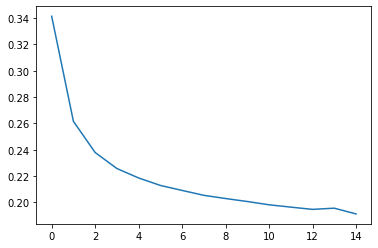

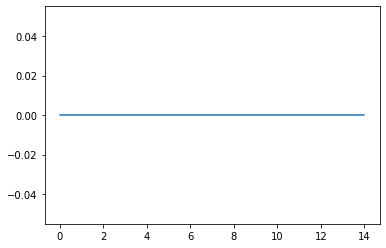

Got to epoch 15


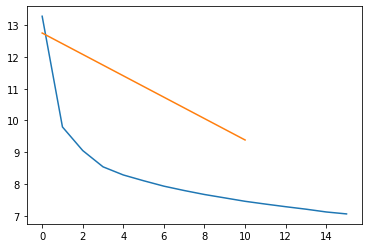

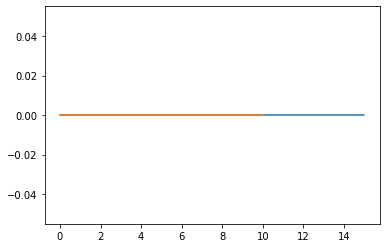

In [84]:
state = show_res(True, 15)
state2 = show_res(False, 15)

<All keys matched successfully>

In [81]:
loader = get_loader(False, 32)

Files already downloaded and verified


In [96]:
model = TestModel(True)
model.load_state_dict(state['model'])

test_its = 1
sigmoid = nn.Sigmoid()
for i, (x, y) in zip(range(test_its), loader):
  # pred = torch.stack(model(x)).permute(1, 0, 2).argmax(dim=2)
  pred = sigmoid(model(x))
  print("Predicted:")
  print((pred > 0.5).int().tolist())
  print("Actual")
  print(y.tolist())

  diff = (pred > 0.5).int().eq(y)
  acc = diff.sum().item() / diff.numel()
  print(f"Accuracy: {acc}")

  num_tg_ones = y.sum().item()
  naive_acc = 1 - (num_tg_ones / diff.numel())
  print(f"Naive acc would be {naive_acc}")


Predicted:
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1], [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0,

In [97]:
model2 = TestModel(False)
model2.load_state_dict(state2["model"])

test_its = 1
sigmoid = nn.Sigmoid()
for i, (x, y) in zip(range(test_its), loader):
  pred = torch.stack(model2(x)).permute(1, 0, 2).argmax(dim=2)
  print("Predicted:")
  print((pred > 0.5).int().tolist())
  print("Actual")
  print(y.tolist())

  diff = (pred > 0.5).int().eq(y)
  acc = diff.sum().item() / diff.numel()
  print(f"Accuracy: {acc}")

  num_tg_ones = y.sum().item()
  naive_acc = 1 - (num_tg_ones / diff.numel())
  print(f"Naive acc would be {naive_acc}")

Predicted:
[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 1, 0,